In [1]:
#Reading the training data Subject
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing all needed libraries
import pandas as pd
import numpy as np #Matric math
import tensorflow as tf #ML
from tensorflow.python.framework import ops
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import sys
import os
from scipy.io import loadmat
from scipy.io import loadmat





## **Prepare Data**

In [3]:
# # --------------------- Full Implementation ---------------------
# import tensorflow as tf
# import numpy as np
# from scipy.io import loadmat
# from scipy.stats import pearsonr
# import matplotlib.pyplot as plt
# from tensorflow.keras import layers, Model, Input

# # --------------------- Biomechanical Components ---------------------
# class MusculoskeletalLayer(layers.Layer):
#     def __init__(self, n_dofs=22, n_muscles=20):
#         super().__init__()
#         self.n_muscles = n_muscles
#         self.n_dofs = n_dofs

#     def build(self, input_shape):
#         input_dim = input_shape[-1]
#         self.muscle_weights = self.add_weight(
#             shape=(input_dim, self.n_muscles),
#             initializer='glorot_uniform',
#             trainable=True
#         )
#         self.moment_arms = self.add_weight(
#             shape=(self.n_muscles, self.n_dofs),
#             initializer='he_normal',
#             trainable=True
#         )

#     def call(self, inputs):
#         muscle_activation = tf.math.sigmoid(tf.matmul(inputs, self.muscle_weights))
#         joint_torque = tf.matmul(muscle_activation, self.moment_arms)
#         return tf.math.tanh(joint_torque)

# # --------------------- Model Architectures ---------------------
# def build_biomechanical_model(input_features=96, timesteps=15):
#     inputs = Input(shape=(timesteps, input_features))
#     x = layers.Bidirectional(layers.LSTM(256, return_sequences=False))(inputs)
#     x = layers.Dense(128, activation='relu')(x)
#     outputs = MusculoskeletalLayer()(x)
#     return Model(inputs, outputs)

# def build_deep_cnn_lstm(input_features=96, timesteps=15):
#     inputs = Input(shape=(timesteps, input_features))

#     # CNN Layers
#     x = layers.Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x)

#     x = layers.Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x)

#     x = layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x)

#     # LSTM Layers
#     x = layers.Bidirectional(layers.LSTM(500, return_sequences=True))(x)
#     x = layers.Dropout(0.2)(x)

#     x = layers.Bidirectional(layers.LSTM(500))(x)
#     x = layers.Dropout(0.2)(x)

#     # Fully Connected Layer
#     outputs = layers.Dense(22, activation='linear')(x)
#     return Model(inputs, outputs)



### **Implement the Model**

In [4]:
# # --------------------- Ensemble Training ---------------------
# class MetaLearner:
#     def __init__(self, model_builders, inner_lr=0.01, meta_lr=0.001):
#         self.models = [builder() for builder in model_builders]
#         self.optimizers = [{
#             'inner': tf.keras.optimizers.Adam(inner_lr),
#             'meta': tf.keras.optimizers.Adam(meta_lr)
#         } for _ in model_builders]

#     def train_on_subjects(self, tasks, epochs=50):
#         for idx, model in enumerate(self.models):
#             print(f"\nTraining {model.name} ({idx+1}/{len(self.models)})")
#             self._train_single_model(model, self.optimizers[idx], tasks, epochs)

#     def _train_single_model(self, model, optimizers, tasks, epochs):
#         inner_opt = optimizers['inner']
#         meta_opt = optimizers['meta']

#         # Reset optimizer variables
#         inner_opt.build(model.trainable_variables)
#         meta_opt.build(model.trainable_variables)

#         for epoch in range(epochs):
#             self._meta_train_step(model, inner_opt, meta_opt, tasks)
#             if (epoch+1) % 10 == 0:
#                 print(f"Epoch {epoch+1}/{epochs} completed")

#     def _meta_train_step(self, model, inner_opt, meta_opt, tasks):
#         meta_grads = [tf.zeros_like(v) for v in model.trainable_variables]

#         for support_x, support_y, query_x, query_y in tasks:
#             original_weights = [tf.identity(v) for v in model.trainable_variables]

#             # Inner loop
#             with tf.GradientTape() as tape:
#                 pred = model(support_x, training=True)
#                 loss = tf.keras.losses.MSE(support_y, pred)
#             grads = tape.gradient(loss, model.trainable_variables)
#             inner_opt.apply_gradients(zip(grads, model.trainable_variables))

#             # Outer loop
#             with tf.GradientTape() as tape:
#                 pred = model(query_x, training=True)
#                 query_loss = tf.keras.losses.MSE(query_y, pred)

#             task_grads = tape.gradient(query_loss, model.trainable_variables)
#             meta_grads = [mg+tg for mg,tg in zip(meta_grads, task_grads)]

#             # Reset weights
#             for v, w in zip(model.trainable_variables, original_weights):
#                 v.assign(w)

#         # Apply meta-update with proper variable tracking
#         avg_grads = [g/len(tasks) for g in meta_grads]
#         meta_opt.apply_gradients(zip(avg_grads, model.trainable_variables))

# # --------------------- Data Pipeline ---------------------
# class DataHandler:
#     def __init__(self, base_path, sequence_length=15):
#         self.base_path = base_path
#         self.sequence_length = sequence_length

#     def load_subject_data(self, subject):
#         data = loadmat(f"{self.base_path}/S{subject}_E1.mat")["Data"]
#         sequences, labels = [], []

#         for i in range(len(data) - self.sequence_length + 1):
#             sequences.append(data[i:i+self.sequence_length, :96])
#             labels.append(data[i+self.sequence_length-1, 96:118])

#         return np.array(sequences), np.array(labels)

#     def prepare_cross_subject_tasks(self, test_subject):
#         train_subjects = [s for s in range(1, 41) if s != test_subject]
#         tasks = []

#         for subject in train_subjects:
#             X, y = self.load_subject_data(subject)
#             split = int(len(X) * 0.8)
#             tasks.append((X[:split], y[:split], X[split:], y[split:]))

#         return tasks



### **MAML**

### **Evaluation , plotting and saving**

In [5]:
# # --------------------- Evaluation & Visualization ---------------------
# class ResultAnalyzer:
#     def __init__(self):
#         self.metrics = {
#             'pearson': [],
#             'rmse': [],
#             'best_dofs': [],
#             'worst_dofs': []
#         }

#     def calculate_metrics(self, y_true, y_pred):
#         pearson = [pearsonr(y_true[:,i], y_pred[:,i])[0] for i in range(22)]
#         rmse = [np.sqrt(np.mean((y_true[:,i]-y_pred[:,i])**2)) for i in range(22)]

#         self.metrics['pearson'].append(np.mean(pearson))
#         self.metrics['rmse'].append(np.mean(rmse))
#         self.metrics['best_dofs'].append(np.argsort(pearson)[-3:])
#         self.metrics['worst_dofs'].append(np.argsort(pearson)[:3])

#         return pearson, rmse

#     def plot_comparison(self, y_true, y_pred, subject):
#         plt.figure(figsize=(15, 20))
#         for dof in range(22):
#             plt.subplot(8, 3, dof+1)
#             plt.plot(y_true[:, dof], label='True', alpha=0.7)
#             plt.plot(y_pred[:, dof], label='Predicted', alpha=0.7)
#             plt.title(f'DOF {dof+1}')
#             plt.legend()
#         plt.suptitle(f"Subject {subject} Predictions", y=0.92)
#         plt.show()

#     def plot_aggregate_results(self):
#         plt.figure(figsize=(12, 6))
#         plt.subplot(1, 2, 1)
#         plt.plot(self.metrics['pearson'], marker='o')
#         plt.title('Average Pearson Correlation')
#         plt.xlabel('Subject')

#         plt.subplot(1, 2, 2)
#         plt.plot(self.metrics['rmse'], marker='o', color='orange')
#         plt.title('Average RMSE')
#         plt.xlabel('Subject')
#         plt.tight_layout()
#         plt.show()

In [6]:
# Save data in Excel file
def savedata(i, correlations):
    """
    Save the correlations data in an Excel file at the specified row.

    Parameters:
    - i: Integer representing the subject number (e.g., 5 for row name 'S5').
    - correlations: List of correlation values to save in the row.
    """
    import openpyxl
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive')

    # Path to the workbook
    workbook_path = '/content/drive/My Drive/Colab Notebooks/dataset/Ninapro Anatomical Model_3CNN 2LSTM_Subject Independant.xlsx'

    # Load the existing workbook
    wb = openpyxl.load_workbook(workbook_path)

    # Select the active sheet
    sheet = wb.active

    # Dynamically set the row name based on 'i'
    row_name = f'S{i}'  # Example: 'S5' if i=5

    # Find the row with the specified row name
    target_row = None
    for row in sheet.iter_rows(min_row=1, max_row=sheet.max_row):
        if row[0].value == row_name:
            target_row = row[0].row
            break

    if target_row is None:
        print(f"Error: Row with name '{row_name}' not found in the sheet.")
        return

    # Write the data to the found row, starting from the second column
    for col, value in enumerate(correlations, start=2):  # Start at column 2 to skip the first column for the label
        sheet.cell(row=target_row, column=col, value=value)

    # Save the workbook
    wb.save(workbook_path)
    print(f"Data successfully saved for row '{row_name}'.")


### **Main**

In [7]:
# if __name__ == "__main__":

#     BASE_PATH = '/content/drive/My Drive/Colab Notebooks/dataset wstimi/8 Features'
#     SEQUENCE_LENGTH = 15

#     # Initialize components
#     data_handler = DataHandler(BASE_PATH, SEQUENCE_LENGTH)
#     analyzer = ResultAnalyzer()

#     # Create ensemble with separate optimizers
#     model_builders = [build_biomechanical_model, build_deep_cnn_lstm]
#     meta_learner = MetaLearner(model_builders)

#     # Cross-subject validation
#     for test_subject in range(1, 41):
#         print(f"\n=== Processing Subject {test_subject} ===")

#         # Prepare data (39 subjects for training)
#         tasks = data_handler.prepare_cross_subject_tasks(test_subject)
#         test_X, test_y = data_handler.load_subject_data(test_subject)

#         # Train ensemble on 39 subjects with proper optimizer isolation
#         meta_learner.train_on_subjects(tasks)

#         # Ensemble predictions
#         predictions = []
#         for model in meta_learner.models:
#             pred = model.predict(test_X)
#             predictions.append(pred)
#         ensemble_pred = np.mean(predictions, axis=0)

#         # Evaluate and plot
#         pearson, rmse = analyzer.calculate_metrics(test_y, ensemble_pred)
#         analyzer.plot_comparison(test_y, ensemble_pred, test_subject)

#         print(f"Subject {test_subject} Results:")
#         print(f"Average Pearson: {np.mean(pearson):.2f}")
#         print(f"Average RMSE: {np.mean(rmse):.2f}")



In [8]:
import tensorflow as tf
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, Model, Input



NUM_EMG_CHANNELS = 12
FEATURES_PER_CHANNEL = 8
TOTAL_FEATURES = NUM_EMG_CHANNELS * FEATURES_PER_CHANNEL
SEQ_LENGTH = 15
DOF_COUNT = 22
VAL_SUBJECTS = 3  # Number of subjects to use for validation

# ===================== ROBUST LOSS FUNCTION =====================
def hybrid_loss(y_true, y_pred):
    """Combination of MSE and Pearson correlation with guaranteed positivity"""
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)  #Correct way to call MSE loss

    # Pearson correlation component
    y_true_mean = tf.reduce_mean(y_true, axis=0)
    y_pred_mean = tf.reduce_mean(y_pred, axis=0)
    covariance = tf.reduce_mean((y_true - y_true_mean) * (y_pred - y_pred_mean))
    std_product = tf.math.reduce_std(y_true) * tf.math.reduce_std(y_pred)
    pearson = covariance / (std_product + 1e-8)

    # Weighted combination (MSE + 1 - Pearson)
    return 0.6 * mse + 0.4 * (1 - pearson)

# ===================== DATA LOADER WITH VALIDATION =====================
class EMGDataset:
    def __init__(self, base_path, subjects):
        self.base_path = base_path
        self.subjects = subjects
        self.scaler = StandardScaler()

    def _load_subject(self, subject):
        data = loadmat(f"{self.base_path}/S{subject}_E1.mat")["Data"]
        features = data[:, :TOTAL_FEATURES]
        labels = data[:, TOTAL_FEATURES:TOTAL_FEATURES+DOF_COUNT]
        return features, labels

    def _create_sequences(self, data, labels):
        sequences = []
        targets = []
        for i in range(len(data) - SEQ_LENGTH + 1):
            sequences.append(data[i:i+SEQ_LENGTH])
            targets.append(labels[i+SEQ_LENGTH-1])
        return np.array(sequences), np.array(targets)

    def load_data(self, test_subject):
        full_data = {}
        all_features = []

        # First pass to collect all features
        for s in self.subjects:
            f, _ = self._load_subject(s)
            all_features.append(f)

        # Identify validation subjects
        train_subjects = [s for s in self.subjects if s != test_subject]
        val_subjects = np.random.choice(train_subjects, VAL_SUBJECTS, replace=False)
        train_subjects = [s for s in train_subjects if s not in val_subjects]

        # Fit scaler on training subjects only
        train_features = np.concatenate([f for s,f in zip(self.subjects, all_features)
                                       if s in train_subjects])
        self.scaler.fit(train_features)

        # Process all subjects
        for s in self.subjects:
            f, l = self._load_subject(s)
            f_scaled = self.scaler.transform(f)
            seq, lab = self._create_sequences(f_scaled, l)
            full_data[s] = (seq.astype(np.float32), lab.astype(np.float32))

        return full_data, train_subjects, val_subjects




In [9]:

# ===================== MODEL ARCHITECTURE =====================
class TemporalModel(tf.keras.Model):
    # def __init__(self):
    #     super().__init__()
    #     self.encoder = tf.keras.Sequential([
    #         layers.Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu'),
    #         layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    #         layers.Bidirectional(layers.LSTM(32)),
    #         layers.Dense(128, activation='relu'),
    #         layers.Dropout(0.2)
    #     ])
    #     self.dof_heads = [layers.Dense(1) for _ in range(DOF_COUNT)]

    def __init__(self):
        super().__init__()
        self.encoder = tf.keras.Sequential([
        # First CNN layer with Batch Normalization
            layers.Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.BatchNormalization(),

        # Second CNN layer with Batch Normalization
            layers.Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.BatchNormalization(),

        # Third CNN layer with Batch Normalization
            layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.BatchNormalization(),

        # Bidirectional LSTMs
            layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(32)),

        # Fully Connected Dense Layer
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2)
    ])

    # Output layers for each DOF
        self.dof_heads = [layers.Dense(1) for _ in range(DOF_COUNT)]

    def call(self, inputs):
        x = self.encoder(inputs)
        return tf.concat([head(x) for head in self.dof_heads], axis=-1)

# ===================== TRAINING FRAMEWORK =====================
class Trainer:
    def __init__(self, model):
        self.model = model
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=1e-3,
                decay_steps=1000,
                decay_rate=0.9
            )
        )
        self.loss_fn = hybrid_loss
        self.best_weights = None

    def train_step(self, inputs, targets):
        with tf.GradientTape() as tape:
            predictions = self.model(inputs, training=True)
            loss = self.loss_fn(targets, predictions)  # Corrected loss call

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss.numpy()

    def evaluate(self, dataset):
        total_loss = 0.0
        count = 0
        for inputs, targets in dataset:
            predictions = self.model(inputs, training=False)
            loss = self.loss_fn(targets, predictions).numpy()  # Ensure scalar value
            total_loss += loss
            count += 1

        return total_loss / count if count > 0 else 0


In [10]:
# --------------------- EVALUATION ---------------------
class DOFEvaluator:
    def __init__(self):
        self.metrics = {
            'pearson': np.zeros(DOF_COUNT),
            'rmse': np.zeros(DOF_COUNT),
            'count': 0
        }

    def update_metrics(self, y_true, y_pred):
        for i in range(DOF_COUNT):
            r_val, _ = pearsonr(y_true[:, i], y_pred[:, i])
            self.metrics['pearson'][i] += r_val
            self.metrics['rmse'][i] += np.sqrt(np.mean((y_true[:, i]-y_pred[:, i])**2))
        self.metrics['count'] += 1

    def plot_results(self):
        avg_pearson = self.metrics['pearson'] / self.metrics['count']

        plt.figure(figsize=(15, 6))
        plt.bar(range(DOF_COUNT), avg_pearson)
        plt.xticks(range(DOF_COUNT), [f'DOF{i}' for i in range(DOF_COUNT)], rotation=90)
        plt.axhline(0.6, color='red', linestyle='--')
        plt.title('Average Pearson Correlation per DOF')
        plt.ylabel('Correlation')
        plt.ylim(-0.5, 1.0)
        plt.show()


=== Testing Subject 34 ===
Epoch 1: Train Loss 0.3531
Validation Loss: 0.3050
Epoch 2: Train Loss 0.3359
Validation Loss: 0.2994
Epoch 3: Train Loss 0.3265
Validation Loss: 0.2942
Epoch 4: Train Loss 0.3189
Validation Loss: 0.2957
Epoch 5: Train Loss 0.3125
Validation Loss: 0.2939
Epoch 6: Train Loss 0.3075
Validation Loss: 0.2955
Epoch 7: Train Loss 0.3035
Validation Loss: 0.2932
Epoch 8: Train Loss 0.3005
Validation Loss: 0.2916
Epoch 9: Train Loss 0.2980
Validation Loss: 0.2912
Epoch 10: Train Loss 0.2959
Validation Loss: 0.2901
Epoch 11: Train Loss 0.2941
Validation Loss: 0.2892
Epoch 12: Train Loss 0.2927
Validation Loss: 0.2885
Epoch 13: Train Loss 0.2916
Validation Loss: 0.2878
Epoch 14: Train Loss 0.2907
Validation Loss: 0.2874
Epoch 15: Train Loss 0.2899
Validation Loss: 0.2871
Epoch 16: Train Loss 0.2893
Validation Loss: 0.2870
Epoch 17: Train Loss 0.2889
Validation Loss: 0.2870
Epoch 18: Train Loss 0.2885
Validation Loss: 0.2871
Epoch 19: Train Loss 0.2882
Validation Loss: 

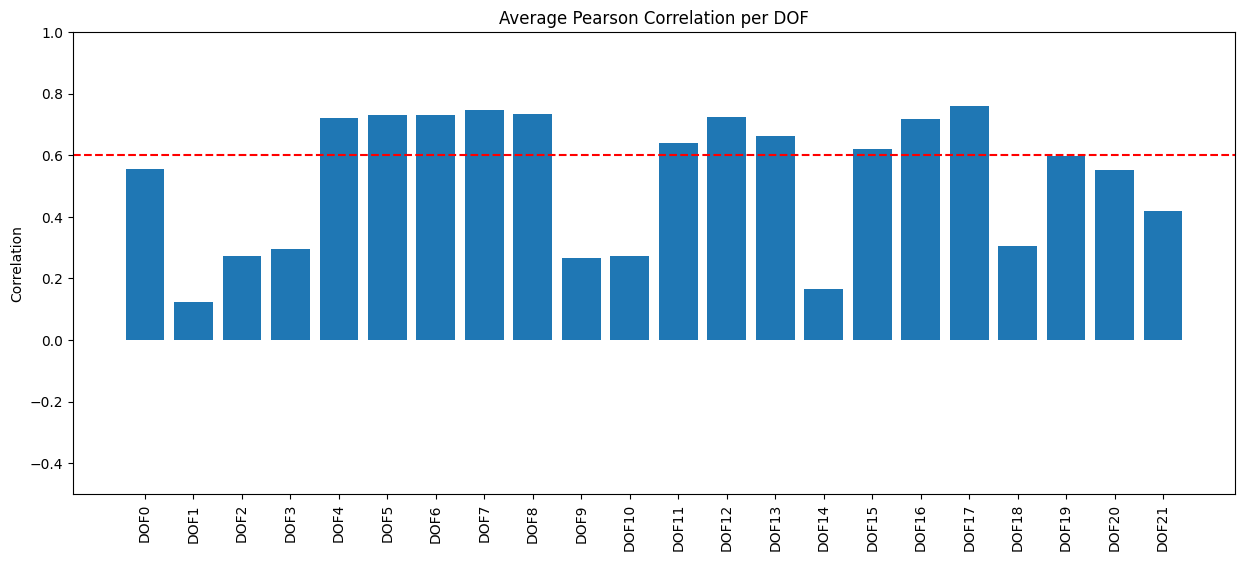

[0.5561749958242636, 0.12212403124908788, 0.2714920430821789, 0.29367603683402044, 0.721416483549833, 0.7296539968370485, 0.7300996580239156, 0.7468399779022755, 0.7334357282428383, 0.2653680916971989, 0.271424898241117, 0.6393457443322549, 0.7228380610637009, 0.6633039345134426, 0.16528507890604827, 0.6204387047962832, 0.7183280529873393, 0.7591025959230236, 0.30393138724606705, 0.5985789663225208, 0.551194948926741, 0.41780608245063583]
Subject 34 - Avg Correlation: 0.53

=== Testing Subject 35 ===
Epoch 1: Train Loss 0.2895
Validation Loss: 0.2947
Epoch 2: Train Loss 0.2889
Validation Loss: 0.2949
Epoch 3: Train Loss 0.2886
Validation Loss: 0.2950
Epoch 4: Train Loss 0.2884
Validation Loss: 0.2951
Epoch 5: Train Loss 0.2883
Validation Loss: 0.2951
Epoch 6: Train Loss 0.2882
Validation Loss: 0.2952
Early stopping
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Subject 35 Results:
Average Pearson: 0.58
Best DOFs: [15  7  4]
Worst DOFs: [21 19  1]
Drive already mounted at /content/drive; to a

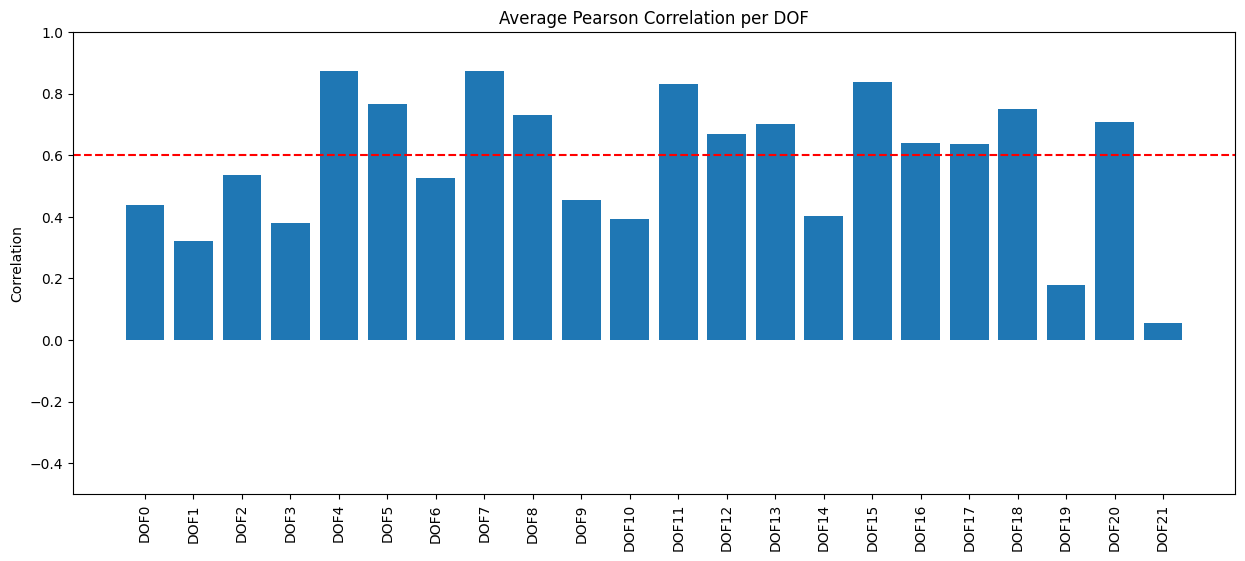

[0.43716308386177505, 0.32065168767029295, 0.5352986215351788, 0.37877093548239066, 0.8737524946603589, 0.7671885877971528, 0.5242600601305675, 0.8722362259874025, 0.730919586416261, 0.45435986383132293, 0.39222197235402173, 0.8305142922934162, 0.6673493241054801, 0.7001933808196382, 0.4027763623249191, 0.836636808313073, 0.6407863357677678, 0.6349616620639769, 0.7508542632814206, 0.17907589009030808, 0.7080510708836749, 0.05502062609093679]
Subject 35 - Avg Correlation: 0.58

=== Testing Subject 36 ===
Epoch 1: Train Loss 0.2897
Validation Loss: 0.2780
Epoch 2: Train Loss 0.2896
Validation Loss: 0.2780
Epoch 3: Train Loss 0.2895
Validation Loss: 0.2780
Epoch 4: Train Loss 0.2895
Validation Loss: 0.2781
Epoch 5: Train Loss 0.2894
Validation Loss: 0.2781
Epoch 6: Train Loss 0.2894
Validation Loss: 0.2781
Early stopping
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Subject 36 Results:
Average Pearson: 0.54
Best DOFs: [11  4  7]
Worst DOFs: [ 6 17 21]
Drive already mounted at /content/drive; t

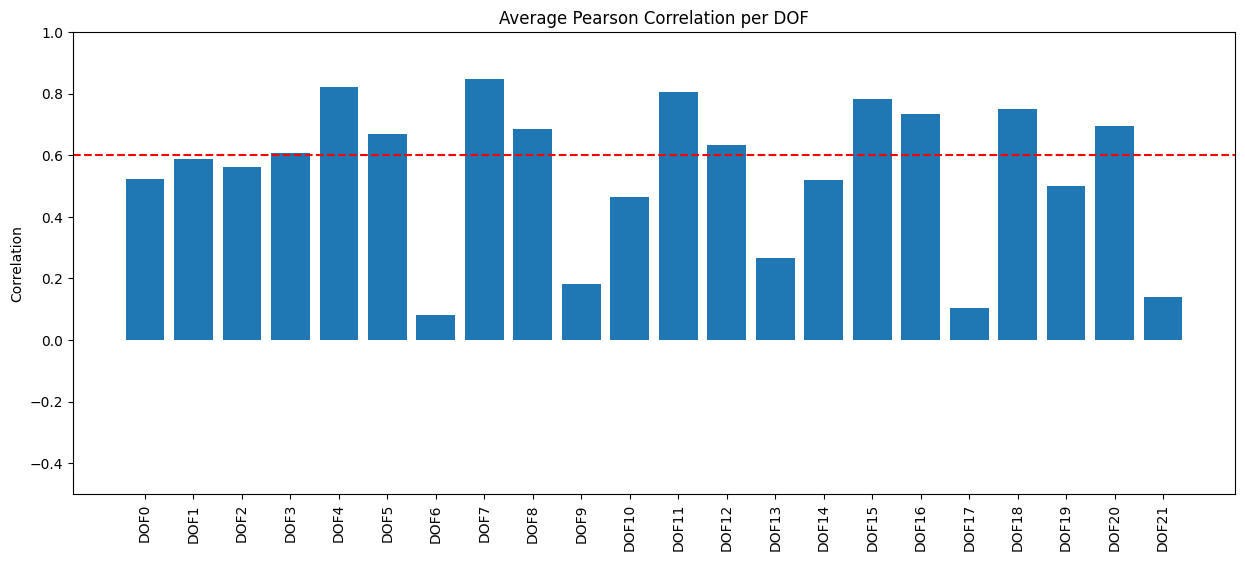

[0.521011311827922, 0.5877155037070965, 0.5601538717605665, 0.6073313965410478, 0.8212178728185481, 0.6681522451535713, 0.0803293191676484, 0.8462685509228461, 0.683321537135981, 0.1823586890131855, 0.46446254744299303, 0.8060829605434546, 0.6335554419513137, 0.2669657360105339, 0.5205946526126438, 0.7806637647052527, 0.7337989239318471, 0.10339877674875504, 0.7488371979849471, 0.49876503780672055, 0.6945460239084333, 0.1403954303994922]
Subject 36 - Avg Correlation: 0.54

=== Testing Subject 37 ===
Epoch 1: Train Loss 0.2904
Validation Loss: 0.2831
Epoch 2: Train Loss 0.2903
Validation Loss: 0.2831
Epoch 3: Train Loss 0.2903
Validation Loss: 0.2832
Epoch 4: Train Loss 0.2903
Validation Loss: 0.2832
Epoch 5: Train Loss 0.2903
Validation Loss: 0.2832
Epoch 6: Train Loss 0.2903
Validation Loss: 0.2832
Early stopping
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Subject 37 Results:
Average Pearson: 0.61
Best DOFs: [16 12  8]
Worst DOFs: [ 2 18  9]
Drive already mounted at /content/drive; to at

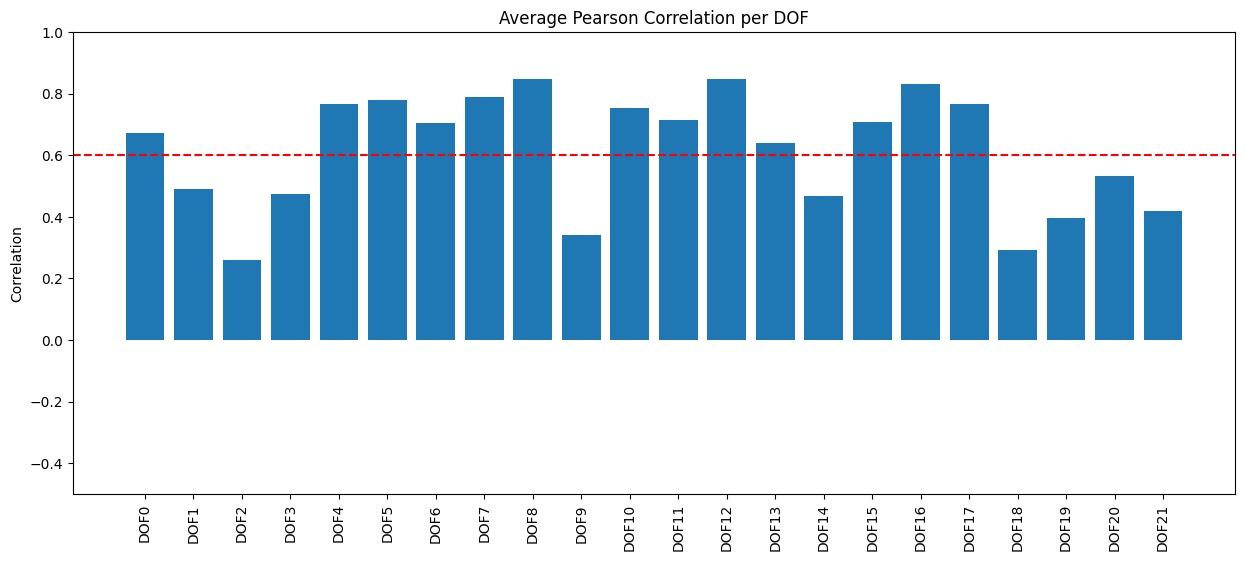

[0.6722760438116414, 0.4902381478662033, 0.25865374323392054, 0.4732716144207437, 0.7666056391010638, 0.7800363243480151, 0.7045042461930684, 0.7882576391564675, 0.8478360688627337, 0.3413847977990088, 0.7524695867700067, 0.7152626235617727, 0.8476603934784971, 0.6393755334293274, 0.46725292189058265, 0.708011088329729, 0.8293219094716571, 0.7669944533645326, 0.292039313648686, 0.3943739760769028, 0.5326016807312282, 0.4183874472211228]
Subject 37 - Avg Correlation: 0.61

=== Testing Subject 38 ===
Epoch 1: Train Loss 0.2916
Validation Loss: 0.2718
Epoch 2: Train Loss 0.2916
Validation Loss: 0.2718
Epoch 3: Train Loss 0.2916
Validation Loss: 0.2718
Epoch 4: Train Loss 0.2916
Validation Loss: 0.2718
Epoch 5: Train Loss 0.2916
Validation Loss: 0.2718
Epoch 6: Train Loss 0.2916
Validation Loss: 0.2718
Epoch 7: Train Loss 0.2916
Validation Loss: 0.2718
Epoch 8: Train Loss 0.2916
Validation Loss: 0.2718
Epoch 9: Train Loss 0.2916
Validation Loss: 0.2718
Epoch 10: Train Loss 0.2916
Validatio

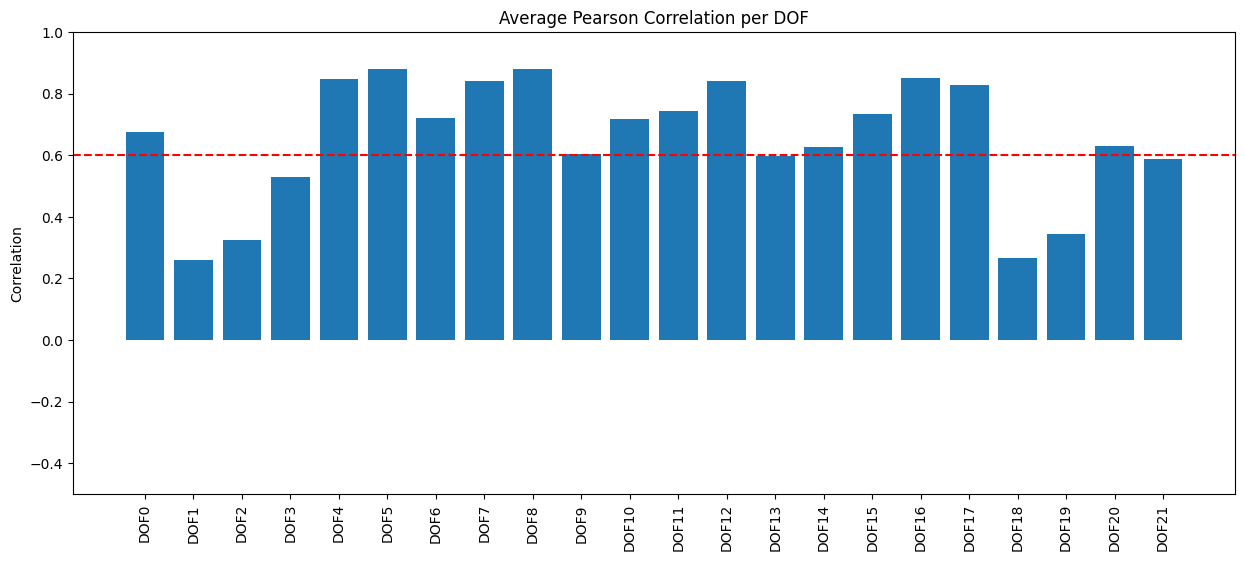

[0.6766046362880529, 0.2596541250248975, 0.3238819006190871, 0.5291675852099025, 0.8469528412119369, 0.8802609772126598, 0.7197971545051748, 0.8390935258634301, 0.8807003874952956, 0.6050864916672811, 0.7160310013272132, 0.7440251437592658, 0.8392100692047639, 0.5974032401014279, 0.6271713861369742, 0.734461100429769, 0.849914528128693, 0.8261992576869073, 0.26447691418244446, 0.34229070042011733, 0.6307707484428638, 0.5867644298421951]
Subject 38 - Avg Correlation: 0.65

=== Testing Subject 39 ===
Epoch 1: Train Loss 0.2876
Validation Loss: 0.3135
Epoch 2: Train Loss 0.2876
Validation Loss: 0.3135
Epoch 3: Train Loss 0.2876
Validation Loss: 0.3135
Epoch 4: Train Loss 0.2876
Validation Loss: 0.3135
Epoch 5: Train Loss 0.2876
Validation Loss: 0.3135
Epoch 6: Train Loss 0.2876
Validation Loss: 0.3135
Epoch 7: Train Loss 0.2876
Validation Loss: 0.3135
Early stopping
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Subject 39 Results:
Average Pearson: 0.58
Best DOFs: [11  4  7]
Worst DOFs: [19  1 

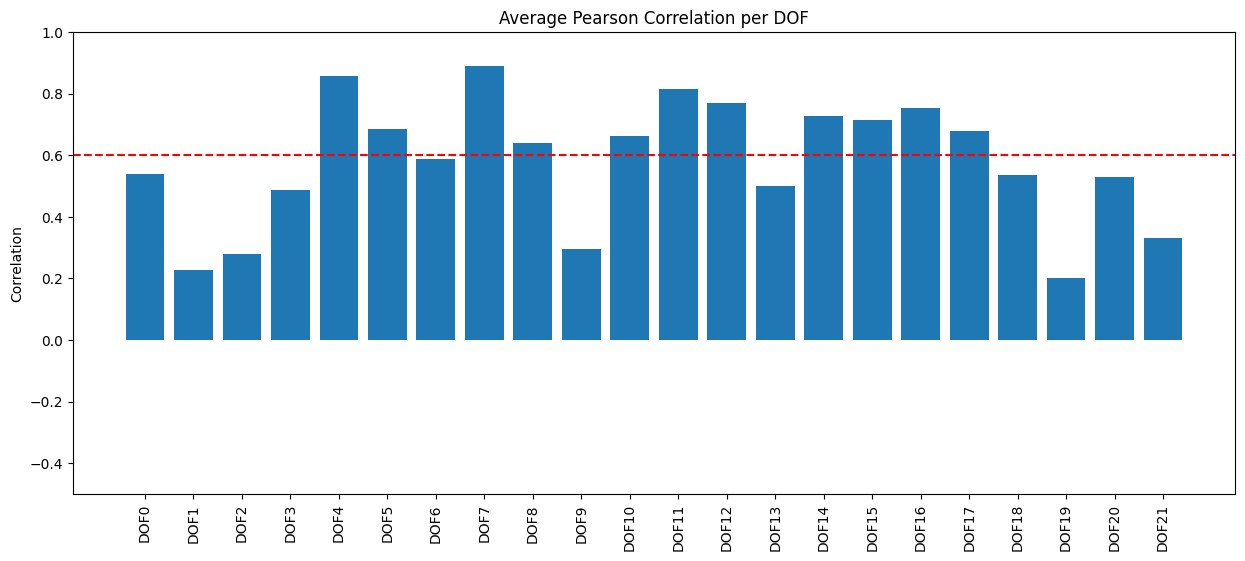

[0.539516070243559, 0.22665225154902183, 0.27742576353756626, 0.48658583236766206, 0.8564591972395151, 0.6860247494241154, 0.5861407423047225, 0.888536777701607, 0.637803771959606, 0.2940137588451605, 0.6635150406566416, 0.8154251502856522, 0.7707088796941555, 0.498367853714307, 0.7280206204028002, 0.7142310653029073, 0.7526035814775638, 0.6783211560307206, 0.5356396164967495, 0.19943007685406983, 0.5289965177516128, 0.32955231019109477]
Subject 39 - Avg Correlation: 0.58

=== Testing Subject 40 ===
Epoch 1: Train Loss 0.2888
Validation Loss: 0.3149
Epoch 2: Train Loss 0.2888
Validation Loss: 0.3149
Epoch 3: Train Loss 0.2888
Validation Loss: 0.3149
Epoch 4: Train Loss 0.2888
Validation Loss: 0.3149
Epoch 5: Train Loss 0.2888
Validation Loss: 0.3149
Epoch 6: Train Loss 0.2888
Validation Loss: 0.3149
Epoch 7: Train Loss 0.2888
Validation Loss: 0.3149
Epoch 8: Train Loss 0.2888
Validation Loss: 0.3149
Epoch 9: Train Loss 0.2888
Validation Loss: 0.3149
Early stopping
280/280 ━━━━━━━━━━━━━

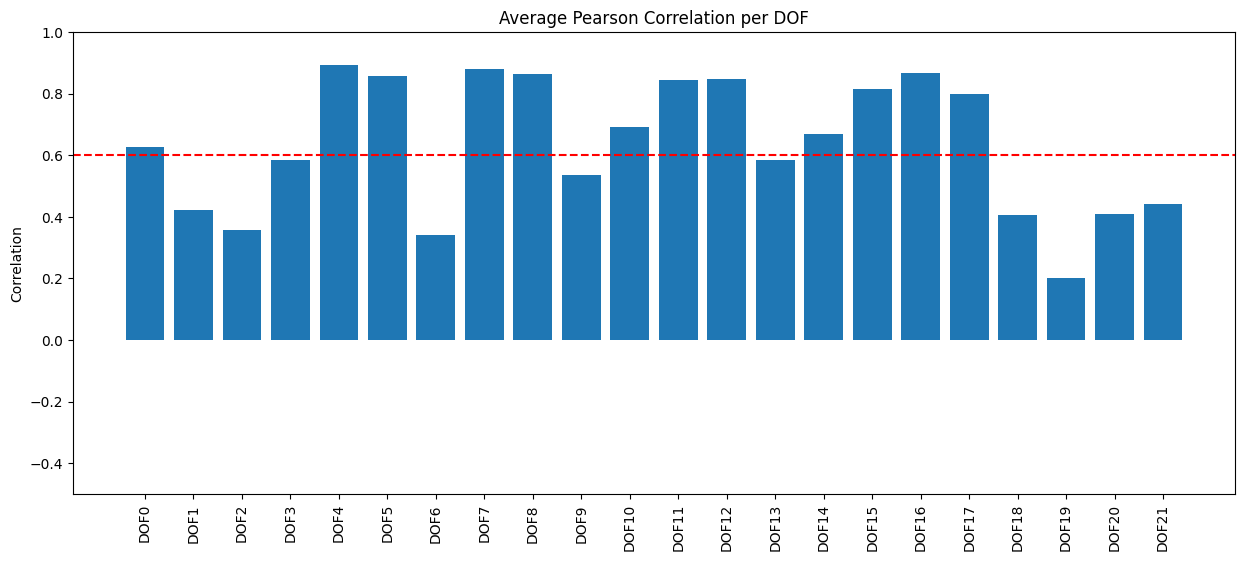

[0.6250010163982964, 0.42233471833217096, 0.3567941961944648, 0.5834314922621118, 0.8937446083807249, 0.8572906349813927, 0.3406348002778324, 0.8798592858586989, 0.8642015009951496, 0.5360741544207068, 0.6907352932135189, 0.8437492938959507, 0.8462549152703713, 0.5838375886496838, 0.6686515477992333, 0.8141761781627099, 0.8679297935270217, 0.7996434449068224, 0.40511366011916744, 0.2018763345692831, 0.40743104315526396, 0.44199069545935654]
Subject 40 - Avg Correlation: 0.63


In [11]:
# --------------------- MAIN EXECUTION ---------------------
from scipy.stats import pearsonr

if __name__ == "__main__":
    model = TemporalModel()
    trainer = Trainer(model)
    dataset = EMGDataset(base_path='/content/drive/My Drive/Colab Notebooks/dataset wstimi/8 Features', subjects=range(1, 41))

    all_subjects = list(range(1, 41))  # Subjects 1 to 40
    start_subject = 34

    for test_subject in all_subjects:
        # Skip subjects that were already processed
        if test_subject < start_subject:
            continue  # Skip to the starting subject

        print(f"\n=== Testing Subject {test_subject} ===")

        # Load data with subject-wise splits
        full_data, train_subs, val_subs = dataset.load_data(test_subject)
        test_seq, test_lab = full_data[test_subject]

        # Prepare datasets
        train_data = [full_data[s] for s in train_subs]
        val_data = [full_data[s] for s in val_subs]

        # Combine and batch data
        train_features = np.concatenate([d[0] for d in train_data])
        train_labels = np.concatenate([d[1] for d in train_data])
        train_ds = tf.data.Dataset.from_tensor_slices(
            (train_features, train_labels)
        ).batch(128)

        val_features = np.concatenate([d[0] for d in val_data])
        val_labels = np.concatenate([d[1] for d in val_data])
        val_ds = tf.data.Dataset.from_tensor_slices(
            (val_features, val_labels)
        ).batch(128)

        # Training with early stopping
        best_val_loss = float('inf')
        patience = 5
        wait = 0

        for epoch in range(20):
            # Training
            epoch_loss = 0.0
            for batch in train_ds:
                loss = trainer.train_step(*batch)
                epoch_loss += loss
            print(f"Epoch {epoch+1}: Train Loss {epoch_loss/len(train_ds):.4f}")

            # Validation
            val_loss = trainer.evaluate(val_ds)
            print(f"Validation Loss: {val_loss:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                wait = 0
                trainer.best_weights = model.get_weights()
            else:
                wait += 1
                if wait >= patience:
                    print("Early stopping")
                    break

        # Restore best weights
        model.set_weights(trainer.best_weights)

        # Final evaluation
        test_pred = model.predict(test_seq)
        pearson_scores = [np.corrcoef(test_lab[:,i], test_pred[:,i])[0,1]
                         for i in range(DOF_COUNT)]
        print(f"Subject {test_subject} Results:")
        print(f"Average Pearson: {np.mean(pearson_scores):.2f}")
        print(f"Best DOFs: {np.argsort(pearson_scores)[-3:]}")
        print(f"Worst DOFs: {np.argsort(pearson_scores)[:3]}")
        savedata(test_subject, pearson_scores)

        dofevaluator = DOFEvaluator()
        dofevaluator.update_metrics(test_lab, test_pred)
        dofevaluator.plot_results()

        print (pearson_scores)
        print(f"Subject {test_subject} - Avg Correlation: {np.mean(pearson_scores):.2f}")